# Autoencoders
Autoencoders are networks constructed and trained with the goal of lossily encoding a large amount of data into an arbitrarily small space. By constructing a diablo- or X-shaped network (one wide end for the input, compressed down to a small middle layer, and expanding out to a large opposite end of equal size to the input), and training with loss defined by the similarity of the input to the output, we gradually approach a middle layer which represents a good amount of our training data's complexity. 

We can feed an autoencoder our dog pics and have it learn their most significant features, and then explore that latent feature space. Let's start by loading in some dogs.

In [1]:
%matplotlib inline

import umap
import numpy as np
import pandas as pd
from scipy.stats import norm
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
data = np.load('../data/full%2Fnumpy_bitmap%2Fdog.npy')
data = data.reshape(-1, 28, 28, 1) / 255.0
X = data[:5000]

# Model with densely encoded layer of arbitrary size
Let's build an autoencoder model with the keras function model and squeeze in a whole load of convolutions. We can define the size of the central encoding layer arbitrarily, which we do in the first line of the next cell. The architecture of the model that follows can be thought of as split into five sections: 

- the input, followed by feature learning convolutional and maxpooling layers,
- shrinking and flattening down to the compressed embedding layer,
- the compressed layer itself,
- more reshaping and some growing back towards the original image size,
- a few more convolutions and the output layer.

The second half of the architecture is pretty interesting - we decode our output image from each compressed layer by passing it through a set of subsequent upsampling and convolutional layers, adding data back between the gaps in the encoded form in a (hopefully) meaningful way.  
This technique can be super useful when building denoising autoencoders. It makes the idea of a sci-fi _"Enhance!"_ from low-res to high-res image totally doable. The results from this kind of work are insanely cool. [Jeremy Howard's examples from fast.ai's lesson 10 are incredible](https://youtu.be/uv0gmrXSXVg?t=1h18m4s).
Anyway... back to dogs.

In [3]:
encoding_size = 32

input_image = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(input_image)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)

x = Flatten()(x)                                        # Squashing
x = Dense(256, activation='relu')(x)                    # Squashing
x = Dropout(0.2)(x)                                     # Squashing
encoded = Dense(encoding_size, activation='relu')(x)    # Dense, encoded layer
x = Dense(64*7*7, activation='relu')(encoded)           # Growing
x = Dropout(0.2)(x)                                     # Growing
x = Reshape((-1, 7, 7, 64)[1:])(x)                      # Growing

x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last')(x)

autoencoder = Model(input_image, decoded)

In [4]:
autoencoder.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['mse'])

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
__________

Lets train it for a few short epochs.

In [5]:
autoencoder.fit(X, X, 
                batch_size=32,
                validation_split=0.2,
                epochs=10)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 25s - loss: 0.3856 - mean_squared_error: 0.0928 - val_loss: 0.3348 - val_mean_squared_error: 0.0777
Epoch 2/10
4000/4000 [==============================] - 27s - loss: 0.3217 - mean_squared_error: 0.0746 - val_loss: 0.3054 - val_mean_squared_error: 0.0697
Epoch 3/10
4000/4000 [==============================] - 27s - loss: 0.3061 - mean_squared_error: 0.0697 - val_loss: 0.2945 - val_mean_squared_error: 0.0661
Epoch 4/10
4000/4000 [==============================] - 37s - loss: 0.2970 - mean_squared_error: 0.0666 - val_loss: 0.2843 - val_mean_squared_error: 0.0625
Epoch 5/10
4000/4000 [==============================] - 39s - loss: 0.2899 - mean_squared_error: 0.0640 - val_loss: 0.2755 - val_mean_squared_error: 0.0595
Epoch 6/10
4000/4000 [==============================] - 36s - loss: 0.2840 - mean_squared_error: 0.0619 - val_loss: 0.2684 - val_mean_squared_error: 0.0569
Epoch 7/10
4000/

And have a look at what it's producing.  
Below we're plotting an input dog, and the output of the network acting on that dog. Pretty good! There's some weird blurring (mostly an artefact of the sigmoid-activated layer that we end on) but it's definitely picking up on the overall shape of the input and doing a decent job of recreating it based on the 32 numbers that it has to work with. We've (lossily) compressed our dog down from 784 dimensions (28x28 pixel image where each pixel is an independent dimension) down to 32 little feature dimensions!

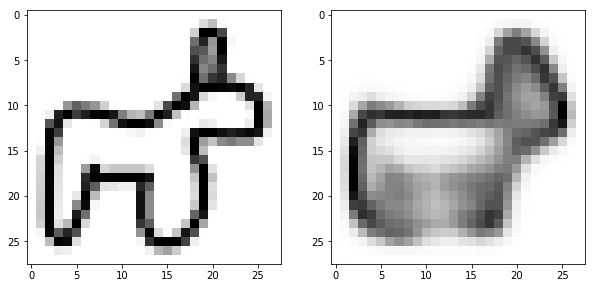

In [56]:
plt.rcParams['figure.figsize'] = (10, 5)

n = np.random.randint(len(data))

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[n].reshape(28, 28),
                cmap='Greys');

axarr[1].imshow(autoencoder.predict(data[n].reshape(1, 28, 28, 1)).reshape(28, 28),
                cmap='Greys');

## Defining an encoder 
We can now separate the two halves of the autoencoder network into an encoder (transforms an image into the latent space) and a decoder (transforms a latent vector into an image). We'll define the same architecture and use the individual layers' weights from the full autoencoder.

In [7]:
input_image = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder.layers[1].get_weights())(input_image)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder.layers[4].get_weights())(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder.layers[7].get_weights())(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Flatten()(x)
x = Dense(256, activation='relu',
          weights=autoencoder.layers[10].get_weights())(x)
x = Dropout(0.2)(x)
encoded = Dense(encoding_size, activation='relu',
          weights=autoencoder.layers[12].get_weights())(x)

encoder = Model(input_image, encoded)

As I said, this encoder model uses the weights from our original autoencoder, so we don't need to do any training here. We can start predicting as soon as the model is instantiated.  
Here's an input image and its numeric representation in the latent space.

[[ 0.          2.10095811  1.83749461  0.66408795  1.71503139  1.57287729
   1.58062065  0.40547961  0.49322531  1.24405968  0.77579725  1.26160681
   2.58604836  0.          6.96411133  3.28345728  0.25506696  0.16495353
   1.65971959  0.86409807  2.79421997  1.52328289  1.96412504  0.
   1.89204407  2.6563673   1.0543102   4.72833061  1.57055116  2.91957641
   0.          1.75113165]]


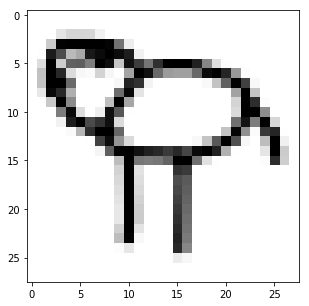

In [8]:
random_image = data[np.random.randint(len(data))].reshape(-1, 28, 28, 1)

print(encoder.predict(random_image))
plt.imshow(random_image.reshape(28, 28), cmap='Greys');

We can apply the encoder to a large set of images, and then UMAP those latent vectors.

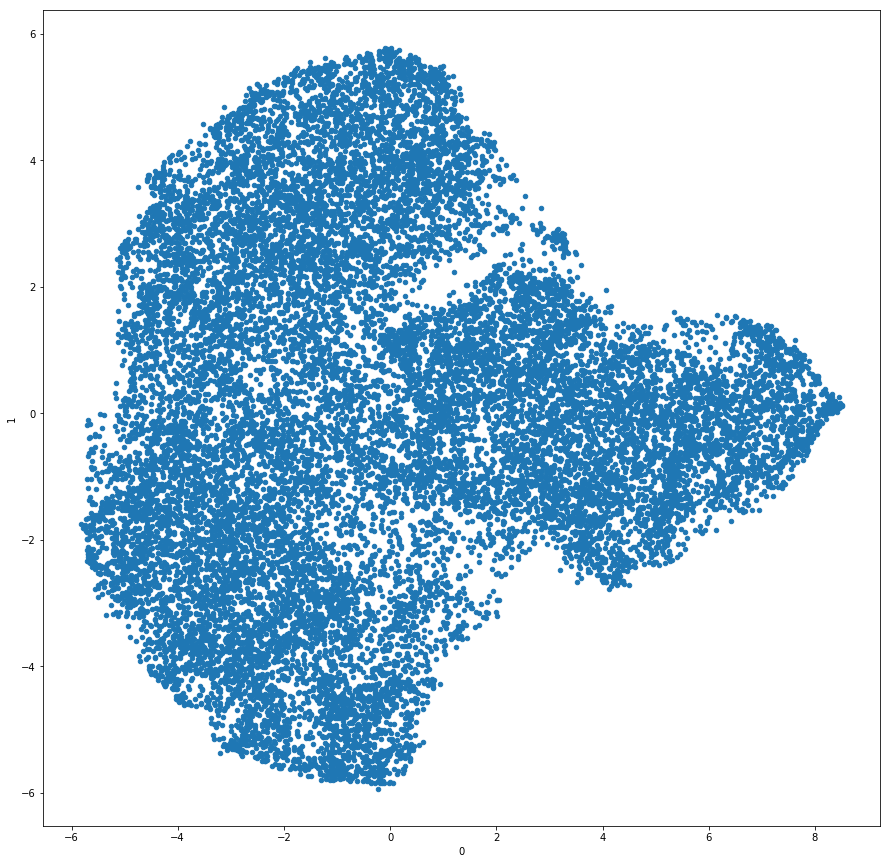

In [9]:
plt.rcParams['figure.figsize'] = (15, 15)

encoded_images = encoder.predict(data[:20000].reshape(-1, 28, 28, 1))
embedding = umap.UMAP().fit_transform(encoded_images)
pd.DataFrame(embedding).plot.scatter(x=0, y=1);

## Defining the associated decoder
Here we're doing exactly the same thing as before, but with the second half of the network. Easy peasy.

In [10]:
latent_vector = Input(shape=(32,))
y = Dense(64*7*7, activation='relu', 
          weights=autoencoder.layers[13].get_weights())(latent_vector)
y = Reshape((-1, 7, 7, 64)[1:])(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', 
           weights=autoencoder.layers[16].get_weights())(y)
y = UpSampling2D((2, 2), data_format='channels_last')(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', 
          weights=autoencoder.layers[18].get_weights())(y)
y = UpSampling2D((2, 2), data_format='channels_last')(y)
y = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last', 
           weights=autoencoder.layers[20].get_weights())(y)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last', 
                 weights=autoencoder.layers[21].get_weights())(y)

decoder = Model(latent_vector, decoded)

We can use this network to decode any point in the latent space we've learned. This is exactly the kind of thing I set out to do in the project's README! 

We can also just grab random points in that latent space and decode them. The results are pretty weird.

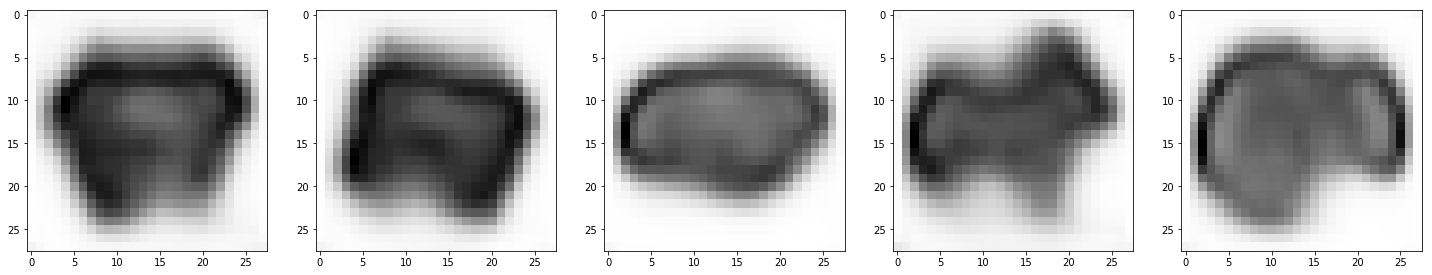

In [11]:
plt.rcParams['figure.figsize'] = (25, 5)
f, axarr = plt.subplots(1, 5)
for i in range(5):
    random_input = np.random.rand(32).reshape(-1, 32)
    axarr[i].imshow(decoder.predict(random_input).reshape(28, 28), cmap='Greys');

The best thing about this encoding is that it's been entirely machine-learned - there are absolutely no\ heuristics involved. The encoding can also be of arbitrary size. That's kind of fine and nice and whatever here, but both of these ideas can be massively useful when working on more abstract, real-world problems (eg. denoising).  
It's worth noting that the encoding layer is really just a small dense layer, and like all neural network layers, the 'meaning' of each of these features in the encoding is completely unspecified and unknown while the model is training. That said, each of the features _can_ be inspected when our latent space has been defined (see next nb).

# Model with simple 2D sampling layer
To explore the latent space efficiently, I'm going to set up a slightly different network using a central sampling layer taking n inputs. This architecture comes from [here](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py) and [here](https://arxiv.org/abs/1312.6114).

In [47]:
latent_dim = 2

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [48]:
input_image = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(input_image)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = MaxPooling2D((2, 2), padding='same', data_format='channels_last')(x)

x = Flatten()(x)                                                             # Squashing
z_mean = Dense(latent_dim)(x)                                                # Squashing
z_log_var = Dense(latent_dim)(x)                                             # Squashing
encoded = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])  # Dense, encoded layer
x = Dense(64*7*7, activation='relu')(encoded)                                # Growing
x = Reshape((-1, 7, 7, 64)[1:])(x)                                           # Growing

x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last')(x)

autoencoder_2 = Model(input_image, decoded)

In [49]:
autoencoder_2.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['mse'])

autoencoder_2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_36 (Conv2D)               (None, 28, 28, 32)    320         input_10[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D)  (None, 14, 14, 32)    0           conv2d_36[0][0]                  
____________________________________________________________________________________________________
dropout_11 (Dropout)             (None, 14, 14, 32)    0           max_pooling2d_13[0][0]           
___________________________________________________________________________________________

In [50]:
autoencoder_2.fit(X, X, 
                  batch_size=32,
                  validation_split=0.2,
                  epochs=10)

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 27s - loss: 0.4140 - mean_squared_error: 0.1007 - val_loss: 0.3461 - val_mean_squared_error: 0.0812
Epoch 2/10
4000/4000 [==============================] - 29s - loss: 0.3428 - mean_squared_error: 0.0804 - val_loss: 0.3322 - val_mean_squared_error: 0.0778
Epoch 3/10
4000/4000 [==============================] - 30s - loss: 0.3348 - mean_squared_error: 0.0783 - val_loss: 0.3282 - val_mean_squared_error: 0.0768
Epoch 4/10
4000/4000 [==============================] - 28s - loss: 0.3315 - mean_squared_error: 0.0775 - val_loss: 0.3252 - val_mean_squared_error: 0.0760
Epoch 5/10
4000/4000 [==============================] - 29s - loss: 0.3291 - mean_squared_error: 0.0769 - val_loss: 0.3244 - val_mean_squared_error: 0.0760
Epoch 6/10
4000/4000 [==============================] - 31s - loss: 0.3275 - mean_squared_error: 0.0766 - val_loss: 0.3224 - val_mean_squared_error: 0.0755
Epoch 7/10
4000/

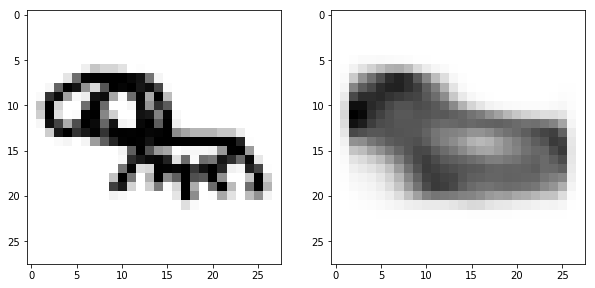

In [51]:
plt.rcParams['figure.figsize'] = (10, 5)

n = np.random.randint(len(data))

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[n].reshape(28, 28),
                cmap='Greys');

axarr[1].imshow(autoencoder_2.predict(data[n].reshape(1, 28, 28, 1)).reshape(28, 28),
                cmap='Greys');

# Exploring the latent space 
We can now plot representations from the 2D latent space we've defined, evenly spread across a continuous manifold.

In [52]:
latent_vector_2 = Input(shape=(latent_dim,))
x = Dense(64*7*7, activation='relu',
          weights=autoencoder_2.layers[10].get_weights())(latent_vector_2)
x = Reshape((-1, 7, 7, 64)[1:])(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder_2.layers[13].get_weights())(x)
x = UpSampling2D((2, 2), data_format='channels_last')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', data_format='channels_last',
           weights=autoencoder_2.layers[15].get_weights())(x)
decoded_2 = Conv2D(1, (3, 3), activation='sigmoid', padding='same', data_format='channels_last',
                   weights=autoencoder_2.layers[16].get_weights())(x)

decoder_2 = Model(latent_vector_2, decoded_2)

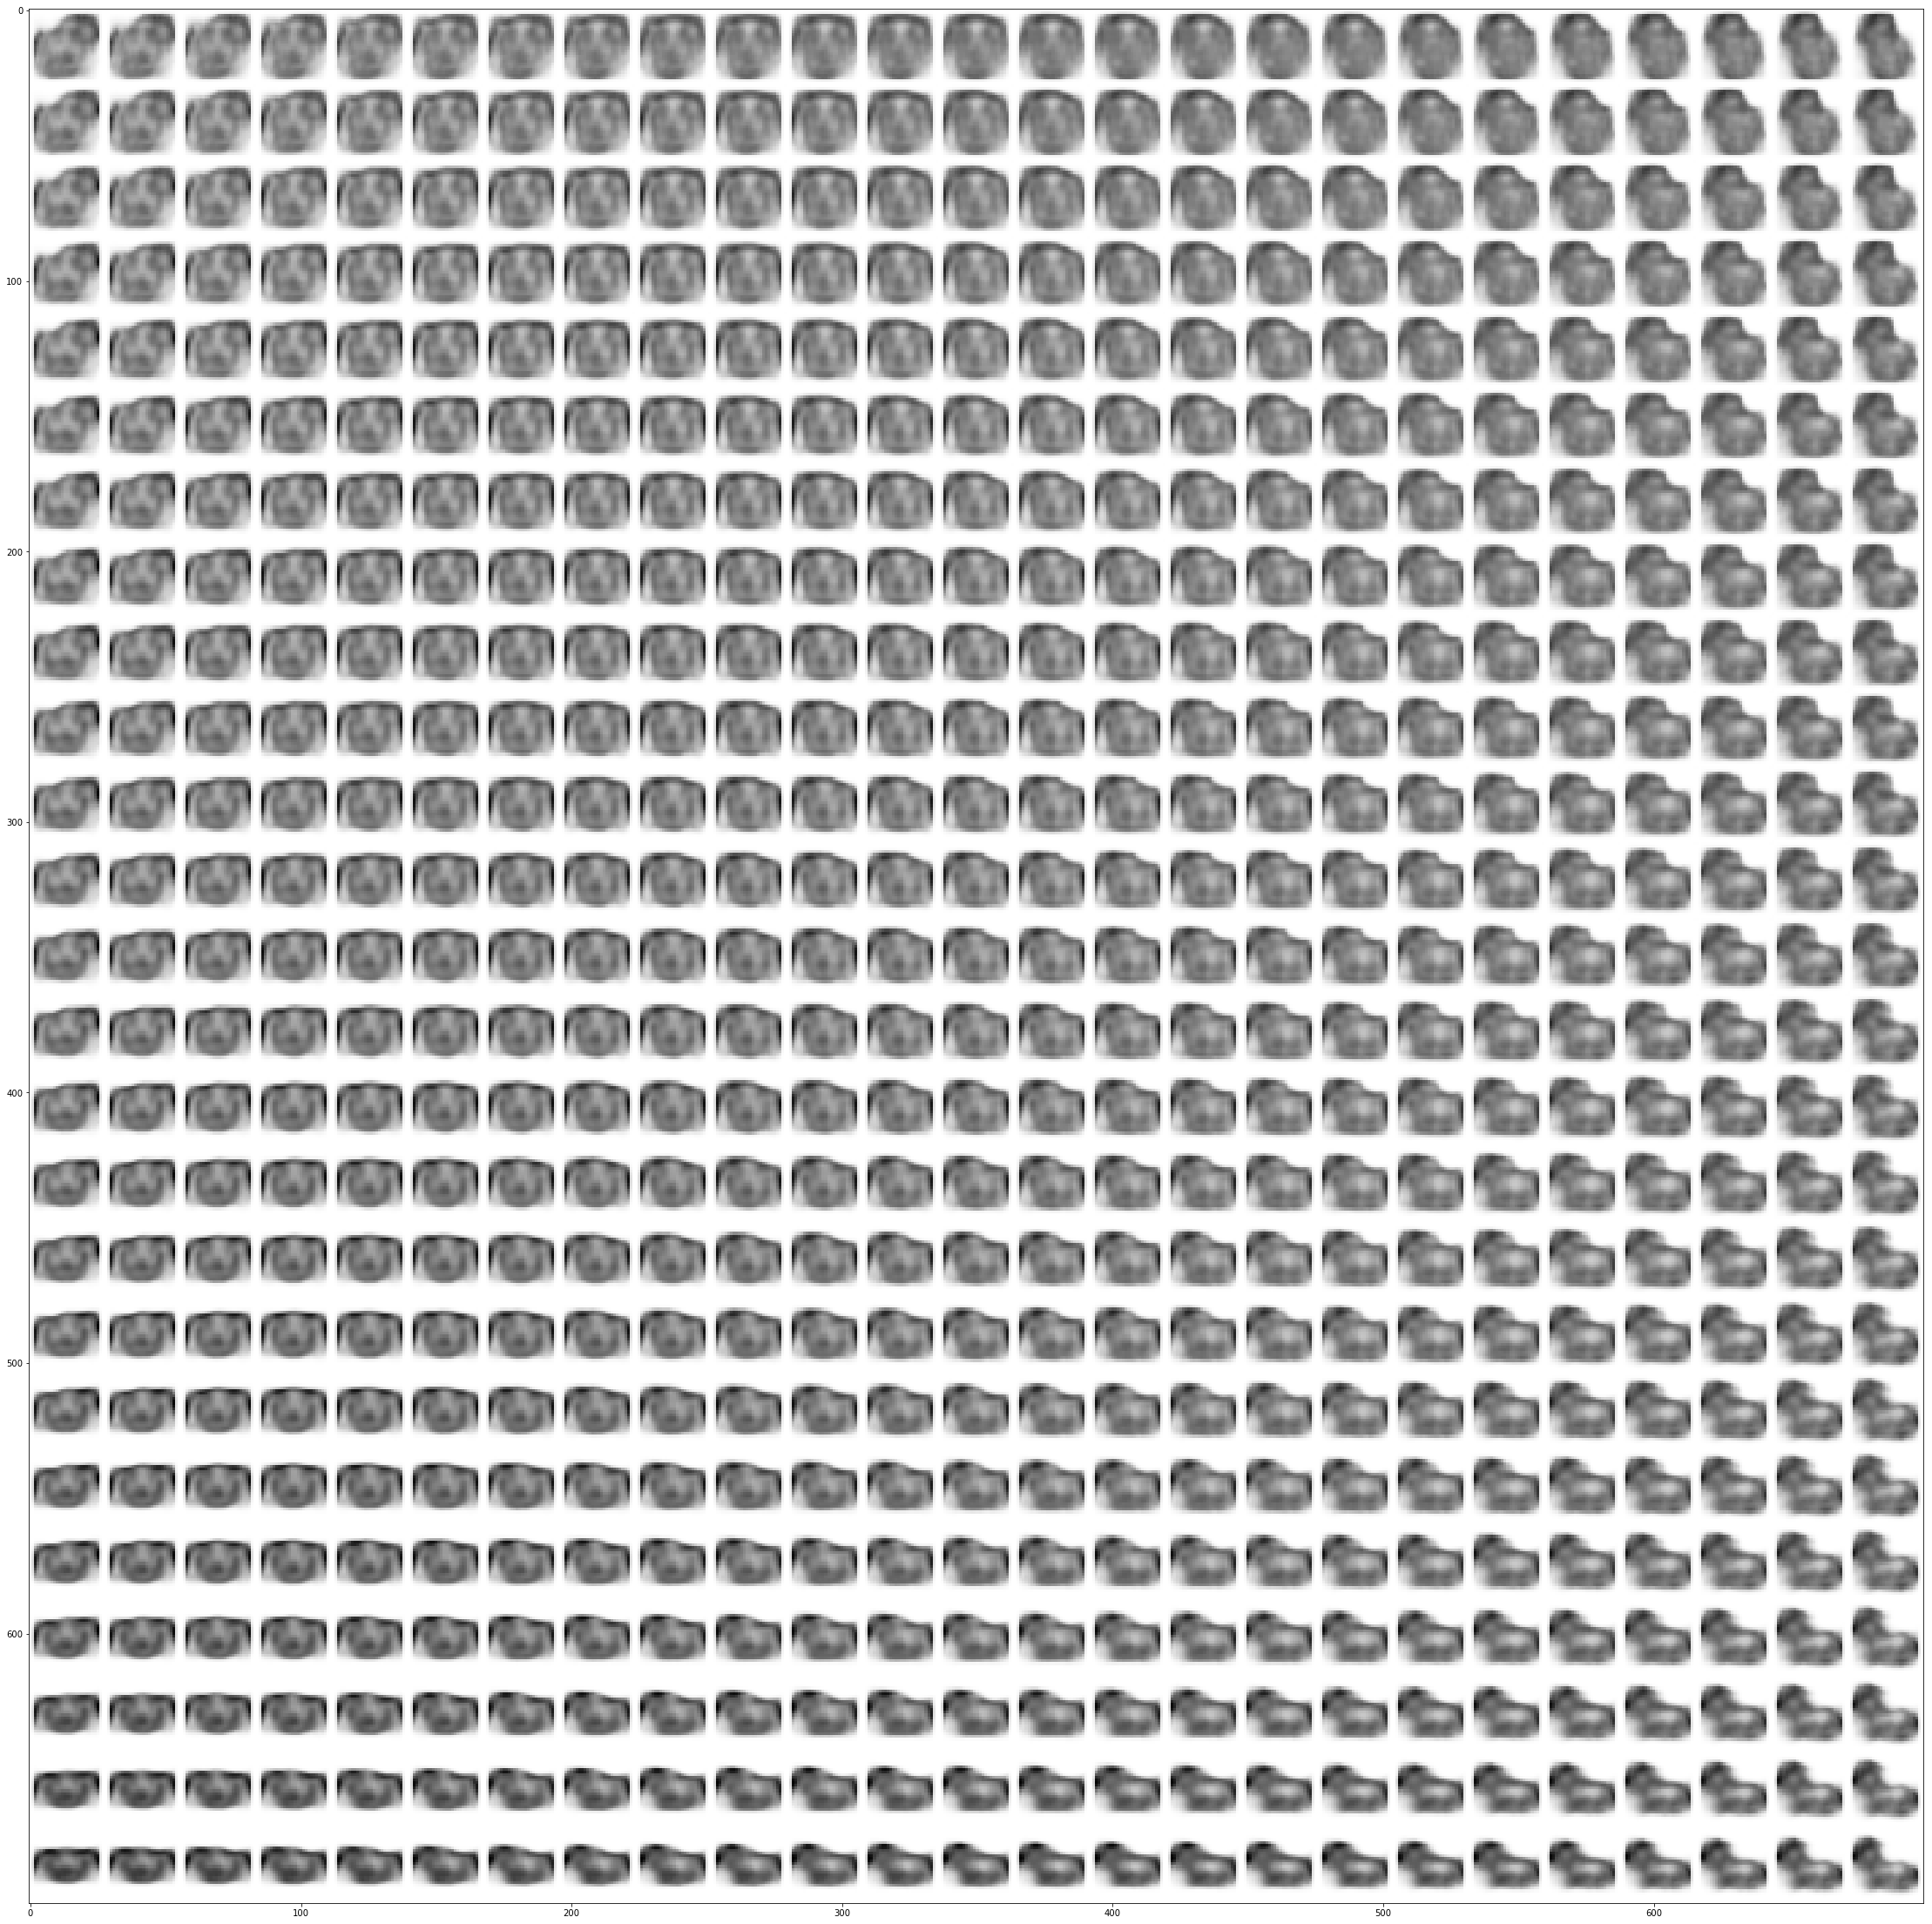

In [53]:
figure = np.zeros((700, 700))
grid_x = norm.ppf(np.linspace(0.05, 0.95, 25))
grid_y = norm.ppf(np.linspace(0.05, 0.95, 25))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        x_decoded = decoder_2.predict(np.array([[xi, yi]]))
        figure[i * 28: (i + 1) * 28, 
               j * 28: (j + 1) * 28] = x_decoded[0].reshape(28, 28)

plt.figure(figsize=(40, 40));
plt.imshow(figure, cmap='Greys');